In [31]:
import random
import cv2 as cv
import numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, HalvingGridSearchCV

from scipy.spatial.distance import euclidean

## Load image pairs dataset

In [2]:
def load_data():
    # path for cloud execution
    X = np.load("/kaggle/input/make-pairs-no-split/X.npy")
    # path for local execution
    #X = np.load("")
    print(X.shape)
    # path fot cloud execution
    y = np.load("/kaggle/input/make-pairs-no-split/y.npy")
    # path for local execution
    #y = np.load("data_pairs/y.npy")
    print(y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = None)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

    del X
    del y

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data()

(30360, 2, 150, 200)
(30360,)


## Grid-Search support function

In [3]:
model_map = {"svm_linear": SVC(kernel = "linear"),
             "svm_rbf": SVC(kernel = "rbf")}

parameters_map = {"C": [0.1, 1, 10],
                          "gamma": [1, 0.1, 0.01]}

def fine_tune(model: str, param_grid: dict, folds:int = 3):
    return HalvingGridSearchCV(model_map[model], param_grid, n_jobs = -1, refit = True, cv = folds, verbose = 3, factor = 3, resource = "n_samples")

## Confusion Matrix plot function

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## HOG distances

### Compute HOG distances

In [27]:
train_distances_arr = []
test_distances_arr = []

In [ ]:
for i, pairs in enumerate(X_train[:]):
    print(f"Iteration number {i+1}")
    hog_1 = hog(pairs[0])
    hog_2 = hog(pairs[1])
    distance = euclidean(hog_1, hog_2)
    train_distances_arr.append(distance)
    
print("Train distances computed")

In [30]:
distances_train = np.array(train_distances_arr)
print(distances_train.shape)

(21252,)


In [ ]:
for i, pairs in enumerate(X_test[:]):
    print(f"Iteration number {i+1}")
    hog_1 = hog(pairs[0])
    hog_2 = hog(pairs[1])
    distance = euclidean(hog_1, hog_2)
    test_distances_arr.append(distance)
    
print("Test distances computed")

In [32]:
distances_test = np.array(test_distances_arr)
print(distances_test.shape)

(9108,)


In [33]:
distances_train_reshape = distances_train.reshape(-1, 1)
print(distances_train_reshape.shape)
distances_test_reshape = distances_test.reshape(-1, 1)
print(distances_test_reshape.shape)

(21252, 1)
(9108, 1)


### Save HOG distances

In [ ]:
# output path for cloud execution
np.save("/kaggle/working/distances_train_reshape.npy", distances_train_reshape)
np.save("/kaggle/working/distances_test_reshape.npy", distances_test_reshape)

# output path for local execution
# np.save("", distances_train_reshape)
# np.save("", distances_test_reshape)

### Load pre-computed HOG distances

In [4]:
# path for cloud execution
# distances_train_reshape = np.load("")
# distances_test_reshape = np.load("")
# y_train = np.load("")
# y_test = np.load("")
# path for local execution
distances_train_reshape = np.load("distances/distances_train_reshape.npy")
distances_test_reshape = np.load("distances/distances_test_reshape.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [5]:
print(distances_train_reshape.shape)
print(distances_test_reshape.shape)
print(y_test.shape)
print(y_train.shape)

(21252, 1)
(9108, 1)
(9108,)
(21252,)


## SVM

### SVM Polynomial

In [6]:
poly_svm = SVC(kernel = "poly", C = 0.1, degree = 3, gamma = 0.1)
poly_svm.fit(distances_train_reshape, y_train)

SVC(C=0.1, gamma=0.1, kernel='poly')

In [7]:
y_pred_poly = poly_svm.predict(distances_test_reshape)

In [9]:
print("Metrics\n" + classification_report(y_test, y_pred_poly))

Metrics
              precision    recall  f1-score   support

         0.0       0.82      0.75      0.78      4627
         1.0       0.76      0.83      0.79      4481

    accuracy                           0.79      9108
   macro avg       0.79      0.79      0.79      9108
weighted avg       0.79      0.79      0.79      9108



Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

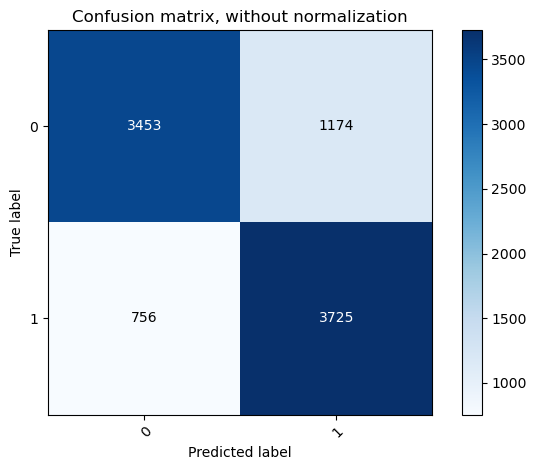

In [39]:
plot_confusion_matrix(y_test, y_pred_poly, classes=np.array(["0", "1"]), normalize=False)

In [10]:
dump(poly_svm, "models/poly_svm.joblib")

['models/poly_svm.joblib']

### SVM Linear

In [11]:
linear_svm = fine_tune("svm_linear", parameters_map)
linear_svm.fit(distances_train_reshape, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2361
max_resources_: 21252
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 2361
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[CV 1/3] END C=0.1, gamma=1;, score=(train=0.787, test=0.803) total time=   0.1s
[CV 3/3] END C=0.1, gamma=0.01;, score=(train=0.806, test=0.771) total time=   0.1s
[CV 3/3] END C=0.1, gamma=0.1;, score=(train=0.806, test=0.771) total time=   0.1s
[CV 1/3] END ..C=1, gamma=1;, score=(train=0.787, test=0.804) total time=   0.1s
[CV 2/3] END ..C=1, gamma=1;, score=(train=0.778, test=0.748) total time=   0.1s
[CV 2/3] END C=0.1, gamma=0.1;, score=(train=0.778, test=0.747) total time=   0.2s
[CV 3/3] END ..C=1, gamma=1;, score=(train=0.806, test=0.771) total time=   0.1s
[CV 2/3] END C=0.1, gamma=1;, score=(train=0.778, test=0.747) total time=   0.3s
[CV 1/3] END C=0.1, gamma=0.1;, score=(train=0.787, test=0.803) total time=   0.2s
[CV 3/3] END C=0.1, gamma=1;, score=(train=0.806, test=0.771) total time=   0.2s
[CV 1/3] END C=1, gamma=0.1;, score=(train=0.787, test=0.804) total time=   0.1s
[CV 1/3] END C=0.1, gamma=0.01;, score=(train=0.787, test=0.803) total time=   0.1s
[CV 2/3] END C=1

HalvingGridSearchCV(cv=3, estimator=SVC(kernel='linear'), n_jobs=-1,
                    param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
                    verbose=3)

In [12]:
print(f"Grid search linear SVM best parameters: {linear_svm.best_params_}")
print(f"Cross validated score of the best linear SVM model: {linear_svm.best_score_}")

Grid search linear SVM best parameters: {'C': 10, 'gamma': 0.01}
Cross validated score of the best linear SVM model: 0.7915666619605628


In [13]:
y_pred_linear = linear_svm.predict(distances_test_reshape)

In [14]:
print("Metrics\n" + classification_report(y_test, y_pred_linear))

Metrics
              precision    recall  f1-score   support

         0.0       0.81      0.76      0.78      4627
         1.0       0.77      0.81      0.79      4481

    accuracy                           0.79      9108
   macro avg       0.79      0.79      0.79      9108
weighted avg       0.79      0.79      0.79      9108



Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

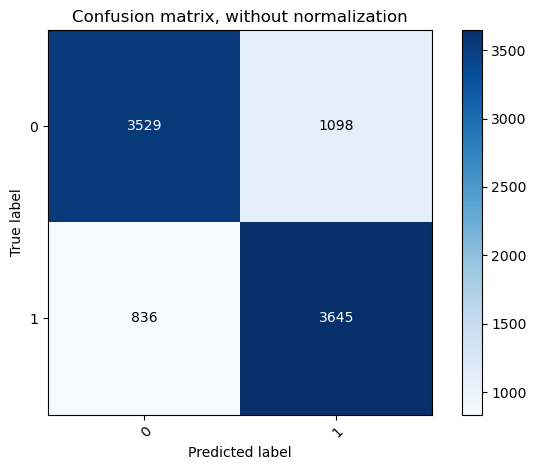

In [40]:
plot_confusion_matrix(y_test, y_pred_linear, classes=np.array(["0", "1"]), normalize=False)

In [15]:
dump(linear_svm.best_estimator_, "models/linear_svm.joblib")

['models/linear_svm.joblib']

### SVM RBF

In [16]:
rbf_svm = fine_tune("svm_rbf", parameters_map)
rbf_svm.fit(distances_train_reshape, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2361
max_resources_: 21252
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 2361
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END C=0.1, gamma=0.1;, score=(train=0.794, test=0.797) total time=   0.2s
[CV 2/3] END C=0.1, gamma=1;, score=(train=0.787, test=0.804) total time=   0.2s
[CV 3/3] END C=0.1, gamma=0.1;, score=(train=0.797, test=0.767) total time=   0.2s
[CV 1/3] END C=0.1, gamma=1;, score=(train=0.792, test=0.793) total time=   0.3s
[CV 3/3] END C=0.1, gamma=1;, score=(train=0.799, test=0.774) total time=   0.3s
[CV 2/3] END C=0.1, gamma=0.1;, score=(train=0.789, test=0.798) total time=   0.3s
[CV 2/3] END C=0.1, gamma=0.01;, score=(train=0.792, test=0.797) total time=   0.3s
[CV 1/3] END C=0.1, gamma=0.01;, score=(train=0.783, test=0.803) total time=   0.3s
[CV 1/3] END ..C=1, gamma=1;, score=(train=0.792, test=0.793) total time=   0.

HalvingGridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
                    param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
                    verbose=3)

In [17]:
print(f"Grid search RBF SVM best parameters: {rbf_svm.best_params_}")
print(f"Cross validated score of the best RBF SVM model: {rbf_svm.best_score_}")

Grid search RBF SVM best parameters: {'C': 1, 'gamma': 1}
Cross validated score of the best RBF SVM model: 0.7912842957315638


In [18]:
y_pred_rbf = rbf_svm.predict(distances_test_reshape)

In [19]:
print("Metrics\n" + classification_report(y_test, y_pred_rbf))

Metrics
              precision    recall  f1-score   support

         0.0       0.81      0.76      0.78      4627
         1.0       0.77      0.82      0.79      4481

    accuracy                           0.79      9108
   macro avg       0.79      0.79      0.79      9108
weighted avg       0.79      0.79      0.79      9108



Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

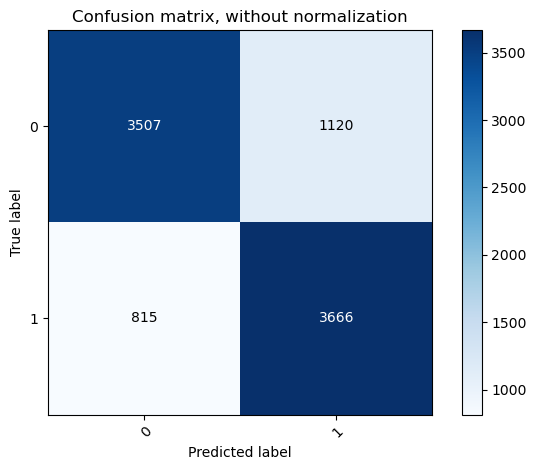

In [41]:
plot_confusion_matrix(y_test, y_pred_rbf, classes=np.array(["0", "1"]), normalize=False)

In [20]:
dump(rbf_svm.best_estimator_, "models/rbf_svm.joblib")

['models/rbf_svm.joblib']